# Homework 01 - Compression

Contact: David C. Schedl (david.schedl@fh-hagenberg.at)

Note: this is the starter pack for the **Visual Computing** homework. You do not need to use this template!

## Task:
Implement your image compression algorithm by exploiting the frequency domain.

When you look at the spectra you will notice that some frequencies have very low-coefficients and thus can be easily removed. How much can be removed before the image quality gets pretty bad?
Think about a way of encoding which frequencies you can remove and what you keep?

Analyze your algorithm on a set of images and evaluate your results concerning quality (e.g., MSE) and size reduction achieved (how many bits could be saved?). Can you make image quality / size reduction a parameter?

Ideally you use (a large) set of different evaluation images (e.g., showing artificial content, buildings, nature, animals, objects, colors, …).
*Hint:* Work with low-res images to speed up computation and avoid huge storage requirements.


**Further comments/hints:**

*   You do not need to come up with a super compression algorithm! It is mostly about getting into the topic.
*   Be creative! 🤔
*   Think about the problem, solve it, and critically evaluate your solution.
*   Summarize your ideas and findings in the report.



**Have fun!** 😸


### Example Dataset: CIFAR 10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It was originally used for Machine Learning, but we can use it for our compression experiments.
For details, see [this website](https://www.cs.toronto.edu/~kriz/cifar.html)!

**Note: you do not need to use CIFAR-10! Any other dataset is fine.**

In [ ]:
# This python package helps you to work with CIFAR-10
!pip install git+https://github.com/schedldave/py-cifar10
import cifar10


  Cloning https://github.com/schedldave/py-cifar10 to /tmp/pip-req-build-2nlo5cip
  Running command git clone --filter=blob:none --quiet https://github.com/schedldave/py-cifar10 /tmp/pip-req-build-2nlo5cip
  Resolved https://github.com/schedldave/py-cifar10 to commit 0b446519a3baf7ba4b5e206c911d9ce2bf06b14b
  Preparing metadata (setup.py) ... done


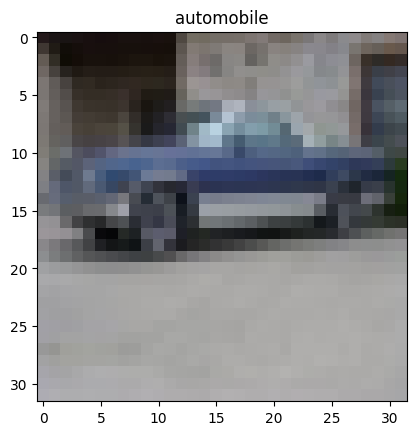

The test set contains 50000 images 
in the following categories:
  airplane: 5000 images
  automobile: 5000 images
  bird: 5000 images
  cat: 5000 images
  deer: 5000 images
  dog: 5000 images
  frog: 5000 images
  horse: 5000 images
  ship: 5000 images
  truck: 5000 images


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

label_map = cifar10.image_label_map() # dictionary to map label integer values to text. i.e., {0: 'airplane', 1: 'automobile', 2: ...}

g = cifar10.data_batch_generator() # CIFAR-10 image generator
image, label = next(g)
# image # numpy array of an image, which is of shape 32 x 32 x 3
# label # integer value of the image label

plt.imshow(image)
plt.title(label_map.get(label))
plt.show()

# count all images
count = 0
count_labels = np.zeros(shape=(len(label_map),), dtype=int)
for image, label in cifar10.data_batch_generator():
  count_labels[label] += 1
  count += 1

print(f'The test set contains {count} images \nin the following categories:')
for i, per_label in enumerate(count_labels):
  print(f'  {label_map.get(i)}: {per_label} images')


### Frequencies: DFT and DCT

The Discrete Fourier Transformation and the Discrete Cosine Transfrom convert a signal into its frequencies. Unlike the Fast Fourier Transformation (FFT) their results are real numbered, which makes it easier to work with them.

The idea and the principle is similar to an FFT.

Below you will find example usages for OpenCV's DFT and DCT implementations:

dtype('float64')


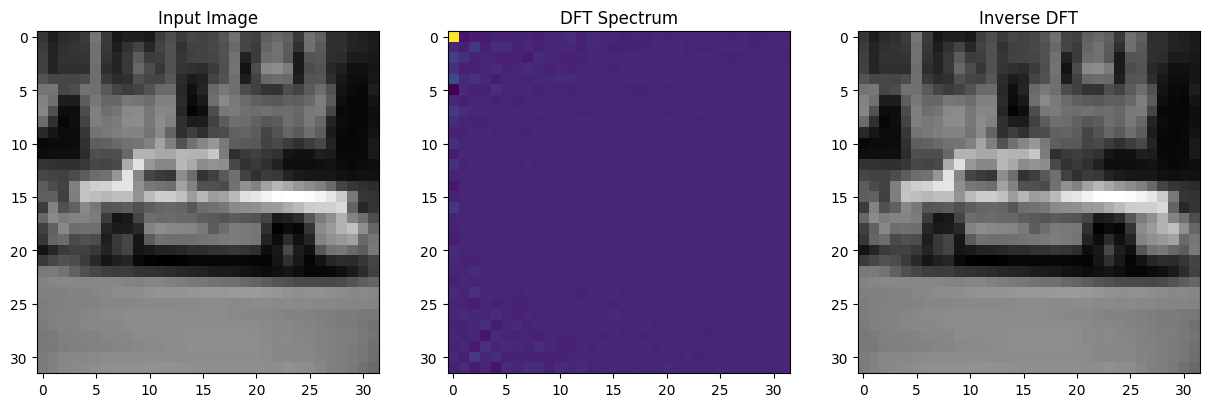

In [ ]:
import cv2

# use a CIFAR-10 image and convert it to grayscale
gray = cv2.cvtColor(cv2.cvtColor(image,cv2.COLOR_BGR2RGB), cv2.COLOR_RGB2GRAY)

# Transform the image to frequency domain using FFT/DFT
f = cv2.dft(gray.astype(np.double))
print(repr(f.dtype)) # The DFT produces a real numbered result

plt.figure(figsize=(15,10))
plt.subplot(131), plt.imshow(gray, cmap = 'gray'), plt.title('Input Image')
plt.subplot(132), plt.imshow(f), plt.title('DFT Spectrum')
plt.subplot(133), plt.imshow(cv2.idft(f, flags=cv2.DFT_SCALE), cmap = 'gray'), plt.title('Inverse DFT')

plt.show()

12
File size: 854980 bytes
File size: 602290 bytes


<ipython-input-74-615393cebdbc>:71: RuntimeWarning: divide by zero encountered in log
  filtered_magnitude_spectrum = 20 * np.log(np.abs(dft_magnitude))


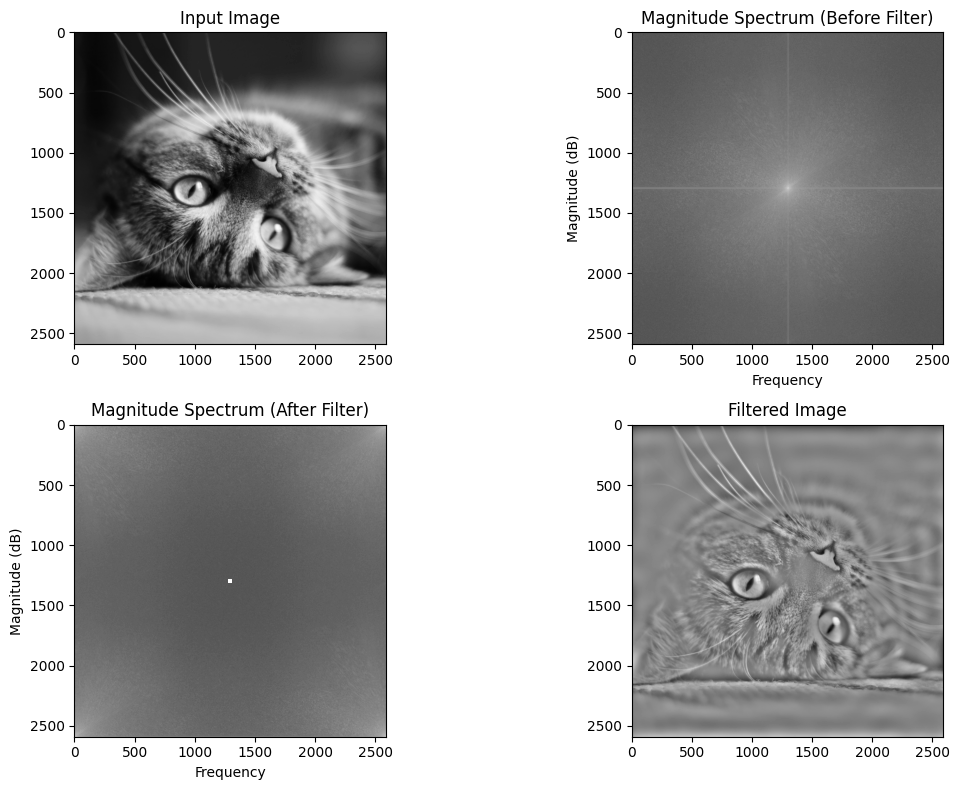

(<Axes: title={'center': 'Filtered Image'}>,
 Text(0.5, 1.0, 'Filtered Image'))

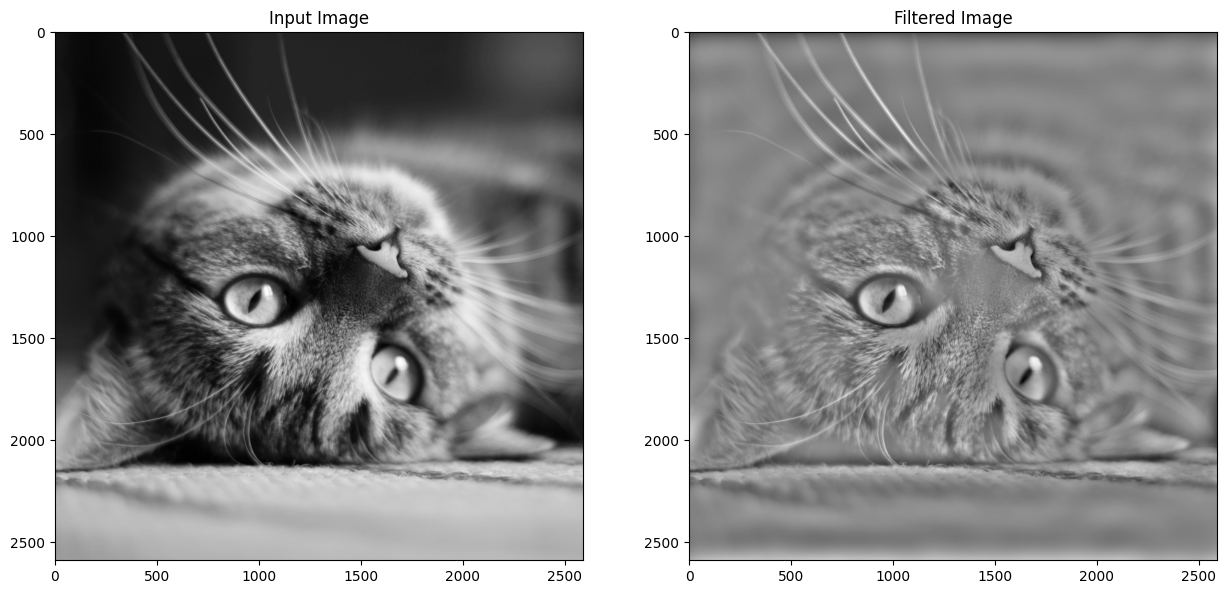

In [ ]:
import numpy.ma as ma
import os

# Define a high-pass filter
def high_pass_filter(dft_magnitude, D):
    #Make a circle
    cy, cx = M//2, N//2
    y, x = np.ogrid[-cy:M-cy, -cx:N-cx]
    mask = x*x + y*y >= D*D
    return mask.astype(int)
image = cv2.imread("/content/cat.jpg", cv2.IMREAD_COLOR)
# use a CIFAR-10 image and convert it to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
N, M = gray.shape

# Transform the image to frequency domain using DFT
dft = np.fft.fftn(np.float32(gray))

dft_magnitude = np.abs(dft)

# Shift the zero frequency component to the center of the spectrum
dft_shift = np.fft.fftshift(dft_magnitude)

# Calculate the magnitude spectrum to show spectral img
magnitude_spectrum = 20 * np.log(np.abs(dft_shift))

# Set block around center of spectrum to zero
D = 12
print(D)
mask = high_pass_filter(dft, D)
dft_magnitude = dft_magnitude * mask

# Shift the mask back to align with the original spectrum
mask = np.fft.ifftshift(mask)

# Make a copy of the original (complex) spectrum
F_dim = dft.copy()

# Set those coefficients to zero
F_dim = F_dim * mask

# Perform inverse Fourier transform to get filtered image
image_filtered = np.real(np.fft.ifft2(F_dim))

cv2.imwrite('original.jpg', gray)
original_file_size = os.path.getsize('original.jpg')
print('File size:', original_file_size, 'bytes')

cv2.imwrite('compressed.jpg', image_filtered)
compressed_file_size = os.path.getsize('compressed.jpg')
print('File size:', compressed_file_size, 'bytes')

# Delete the temporary file
os.remove('original.jpg')
os.remove('compressed.jpg')


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot the original grayscale image
axs[0, 0].imshow(gray, cmap='gray')
axs[0, 0].set_title('Input Image')

# Calculate the magnitude spectrum before the filter with logarithmic scaling
axs[0, 1].imshow(magnitude_spectrum, cmap='gray')
axs[0, 1].set_title('Magnitude Spectrum (Before Filter)')
axs[0, 1].set_xlabel('Frequency')
axs[0, 1].set_ylabel('Magnitude (dB)')


filtered_magnitude_spectrum = 20 * np.log(np.abs(dft_magnitude))

# Plot the magnitude spectrum after the filter with logarithmic scaling
axs[1, 0].imshow(filtered_magnitude_spectrum, cmap='gray')
axs[1, 0].set_title('Magnitude Spectrum (After Filter)')
axs[1, 0].set_xlabel('Frequency')
axs[1, 0].set_ylabel('Magnitude (dB)')

# Plot the filtered image
axs[1, 1].imshow(image_filtered, cmap='gray')
axs[1, 1].set_title('Filtered Image')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(121), plt.imshow(gray, cmap = 'gray'), plt.title('Input Image')
plt.subplot(122), plt.imshow(image_filtered, cmap = 'gray'), plt.title('Filtered Image')



In [ ]:
def MSE(A,B):
  """compute the mean squared error (MSE) between numpy array A and B
  """
  return ((A - B)**2).mean(axis=None)

print( f'MSE: {MSE(gray, image_filtered)}' ) # should be very low!


MSE: 8595.136857032776
